# Clustering to Detect Patterns of Interest

### Importing useful libraries

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import connected_components
import collections
import gensim
import pyemd
import statistics
try:
    import cPickle as pickle
except:
    import pickle
    
    
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Loading data

In [0]:
def concat(google, n):
    '''
    Returns a dataset with an aggregated GID at selected level
    '''
    google = google.fillna('')
    google['concatenation_'+''.join([str(x) for x in range(1, n+1)])] = ""
    assert(n) < 7
    delim = ''
    for i in range(1,n+1):
        if i > 1:
            delim = ' - '
        google['concatenation_'+''.join([str(x) for x in range(1, n+1)])] = google['concatenation_'+''.join([str(x) for x in range(1, n+1)])] + delim + google['uc_level_'+str(i)] 
    return google

In [0]:
DEPTH = 3 # à modifier, minimum =1, maximum = 7
dataset = pd.read_csv('meryem_dataset.csv', sep = '\t').drop(9411) # Absurd GID
dataset.product_Gid = dataset.product_Gid.astype(int)
gid_taxonomy = dataset.product_Gid.unique().astype(int)
google = concat(pd.read_csv('google_product_taxonomy2.csv', sep = ';'), DEPTH)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Aggregating GIDs

In [0]:
mapping = {}
grouped_google = google.groupby(['concatenation_' + ''.join([str(x) for x in range(1,DEPTH+1)]), 'uc_id']).uc_level_1.count()
for concatenation, df in grouped_google.groupby(level = 0):
    to_be_mapped = df.reset_index().uc_id.tolist()
    value = to_be_mapped[0]
    for gid in to_be_mapped:
        mapping[gid] = value
        
dataset['product_Gid_2'] = dataset.product_Gid.map(mapping)
# product_Gid_2 corresponds to an aggregation of gid to the chosen level above

### Filtering relevant GIDs

2441.0499999999906

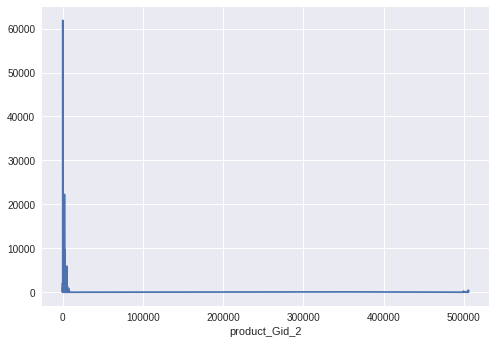

In [0]:
dataset.groupby('product_Gid_2').user_id.nunique().plot()
dataset.groupby('product_Gid_2').user_id.nunique().describe()
dataset.groupby('product_Gid_2').user_id.nunique().quantile(0.95) # 2441

In [0]:
filtering_gid = dataset.groupby('product_Gid_2').user_id.nunique()
# removes gid with only 1 view or with too many views as both do not convey informations on pattern interests
dataset = dataset.loc[dataset['product_Gid_2'].isin(filtering_gid[(filtering_gid < 2441) & (filtering_gid > 1)].index)]

### Creating adjacency matrix

In [0]:
unique_gid_list = dataset.product_Gid_2.unique()
grouped_dataset = dataset.groupby(['product_Gid_2', 'user_id']).nb_views.sum()

def get_gid_dict(gid):
    '''
    Returns all uid associated to a gid
    '''
    return (gid, grouped_dataset.loc[int(gid),:].to_dict())

def create_gid_dict_list():
    '''
    Returns a dictionary.
    Each key corresponds to a single gid
    Each value corresponds to a dictionary in which there are the uid as key and the number of view as value
    '''
    gid_list = {}
    for gid in unique_gid_list:
        current_gid = get_gid_dict(gid)
        gid_list[current_gid[0]] = current_gid[1]
    return gid_list

def affinity(dict_1, dict_2):
    '''
    Affinity measure between two gid
    Does not take into account the number of view anymore
    '''
    keys_a = set(list(zip(*dict_1.keys()))[1])
    keys_b = set(list(zip(*dict_2.keys()))[1])
    denom = min(len(dict_1), len(dict_2))
    num = 0
    intersection = keys_a & keys_b
    num = len(intersection)
    dist = num / denom
    if dist < 0.3: # threshold below which edge is cut
        dist = 0
    return dist

In [0]:
gid_list = create_gid_dict_list()
adj_mat = np.identity(len(unique_gid_list)) * 0.5
print('*** Size of the adjacency matrix: {}'.format(adj_mat.shape))
gid_mapping = {x: y for x, y in enumerate(unique_gid_list)}

for row in gid_mapping.keys():
    if row % 10 == 0:
        print(row)
    for column in range(row):
        dict_1 = gid_list[gid_mapping[row]]
        dict_2 = gid_list[gid_mapping[column]]
        adj_mat[row, column] = affinity(dict_1, dict_2)

adj_mat = adj_mat + adj_mat.T

*** Size of the adjacency matrix: (793, 793)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


### Removing disconnected GIDs

In [0]:
# removes GIDs that are not connected to other GIDs
disconnected_gid = []
bad_row = []
for gid in np.where(adj_mat.sum(axis =1) == 1)[0]:
    bad_row.append(gid)
    disconnected_gid.append(gid_mapping[gid])
          
adj_mat = np.delete(np.delete(adj_mat, bad_row, 1), bad_row, 0)

# doing new mapping
new_mapping = {}
i=0
for row in gid_mapping.keys():
    if gid_mapping[row] not in disconnected_gid:
        new_mapping[i] = gid_mapping[row]
        i+=1
gid_mapping = new_mapping

### Plotting adjacency matrix

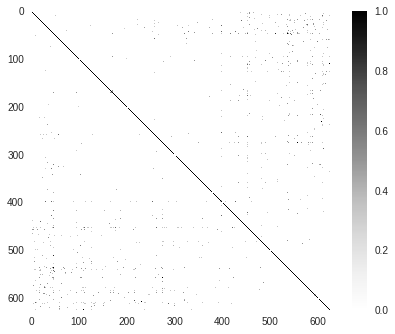

In [0]:
plt.imshow(adj_mat)
plt.colorbar()
plt.show()

### Saving adjacency matrix

In [0]:
with open('190313_adjacency_matrix_d2_p3.crit', 'wb') as f:
    pickle.dump(adj_mat, f)

### Exporting graph

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


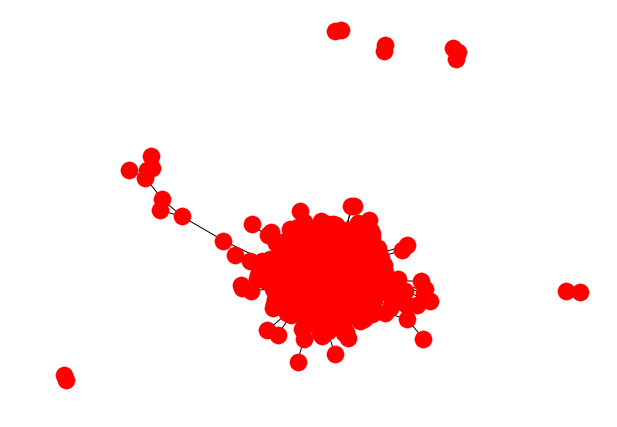

In [0]:
G1 = nx.from_numpy_matrix(adj_mat)
nx.draw(G1)
nx.write_gexf(G1, '190313_adj_mat_d2_p3.gexf')

### Retrieving adjacency matrix for each subconnected component

In [0]:
n_components, cluster = connected_components(adj_mat)

sub_component = []
for x in range(n_components):
    a=np.where(cluster == x)[0]
    sub_adj_mat = adj_mat[np.ix_(a,a)]
    i = 0
    new_gid_mapping = {}
    for row in a:
        new_gid_mapping[i] = gid_mapping[row]
        i+=1
    sub_component.append((sub_adj_mat, new_gid_mapping))

# Focusing on Largest Connected Component solely (more analysis possible on other connected components)
adj_mat = sub_component[0][0]
gid_mapping = sub_component[0][1]

## Performing Spectral Clustering

### Computing Traditional Scores

In [0]:
# Silhouette score
best_cluster={}
for i in range(2, 31):
    spec = SpectralClustering(n_clusters = i, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='precomputed', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)
    silhouette = silhouette_score(adj_mat, spec.fit_predict(adj_mat), metric='precomputed')
    print('Cluster: {}. Silhouette: {}'.format(i, silhouette))
    best_cluster[i] = silhouette

Cluster: 2. Silhouette: -0.9968441303784528
Cluster: 3. Silhouette: -1.0
Cluster: 4. Silhouette: -1.0
Cluster: 5. Silhouette: -1.0
Cluster: 6. Silhouette: -1.0
Cluster: 7. Silhouette: -1.0
Cluster: 8. Silhouette: -1.0
Cluster: 9. Silhouette: -1.0
Cluster: 10. Silhouette: -1.0
Cluster: 11. Silhouette: -1.0
Cluster: 12. Silhouette: -1.0
Cluster: 13. Silhouette: -1.0
Cluster: 14. Silhouette: -1.0
Cluster: 15. Silhouette: -1.0
Cluster: 16. Silhouette: -1.0
Cluster: 17. Silhouette: -1.0
Cluster: 18. Silhouette: -1.0
Cluster: 19. Silhouette: -1.0
Cluster: 20. Silhouette: -1.0
Cluster: 21. Silhouette: -1.0
Cluster: 22. Silhouette: -1.0
Cluster: 23. Silhouette: -1.0
Cluster: 24. Silhouette: -1.0
Cluster: 25. Silhouette: -1.0
Cluster: 26. Silhouette: -1.0
Cluster: 27. Silhouette: -1.0
Cluster: 28. Silhouette: -1.0
Cluster: 29. Silhouette: -1.0
Cluster: 30. Silhouette: -1.0


In [0]:
# Davies Bouldin score
best_cluster={}
for i in range(2, 31):
    spec = SpectralClustering(n_clusters = i, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)
    davies_bouldin = davies_bouldin_score(adj_mat, spec.fit_predict(adj_mat))
    print('Cluster: {}. davies_bouldin score: {}'.format(i, davies_bouldin))
    best_cluster[i] = davies_bouldin

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in 

Cluster: 2. davies_bouldin score: 0.8019572850618992
Cluster: 3. davies_bouldin score: 0.7047662390800702
Cluster: 4. davies_bouldin score: 0.6753796105409406


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 5. davies_bouldin score: 1.0551936226666718
Cluster: 6. davies_bouldin score: 1.0719247521805473
Cluster: 7. davies_bouldin score: 2.0126732191044368


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 8. davies_bouldin score: 1.823220350629599
Cluster: 9. davies_bouldin score: 2.0598002669287094


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 10. davies_bouldin score: 1.8352939545996398
Cluster: 11. davies_bouldin score: 1.6270584463581719


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 12. davies_bouldin score: 1.9689142791528562


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 13. davies_bouldin score: 1.906649116194802
Cluster: 14. davies_bouldin score: 1.5065840852515155


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 15. davies_bouldin score: 1.8892231792431842
Cluster: 16. davies_bouldin score: 1.8647116000419701


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 17. davies_bouldin score: 1.9642963977923056
Cluster: 18. davies_bouldin score: 1.8470564112228847


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 19. davies_bouldin score: 1.7104693496747818
Cluster: 20. davies_bouldin score: 1.6035286939791071


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 21. davies_bouldin score: 1.4778852256014854
Cluster: 22. davies_bouldin score: 1.6582722881472542


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 23. davies_bouldin score: 1.839858862267114
Cluster: 24. davies_bouldin score: 1.6539123836963219


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TA

Cluster: 25. davies_bouldin score: 1.8522461694496712
Cluster: 26. davies_bouldin score: 1.824030695050004


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=pre

Cluster: 27. davies_bouldin score: 1.7067049837147594


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


Cluster: 28. davies_bouldin score: 1.9310162412550897


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


Cluster: 29. davies_bouldin score: 1.6488309921782411
Cluster: 30. davies_bouldin score: 1.8685708511342305


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


### Computing NLP-based Score

In [0]:
#Importing Word2Vec Model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [0]:
def compute_wmd_per_cluster(dataset, model):
    '''
    Computes the mean Word Mover's Distance for categories in each cluster
    :param dataset: dataset with clusters (pandas DataFrame with columns "cluster, Concatenation")
    :param model: trained w2v model 
    :return: 
        dict_wmd : dictionary with wmd score for each cluster
        dict_wmd_per_sentence : dictionary with wmd score for each pair of categories in each cluster

    '''
    
    clusters_list = dataset['cluster'].unique()
    #Initialize the outputs
    dict_wmd = {}
    dict_wmd_per_sentence = {}
    
    sum_wmd = 0
    count_non_isolated = 0
    
    #Iterate over clusters
    for cluster in clusters_list:
        dataset_cluster = dataset[dataset.cluster == cluster]
        categories = dataset_cluster['Concatenation '].unique()
        
        #Create a list 'categories_clean' with cleaned categories (remove '&' and '-' characters)
        categories_clean = []
        for category in categories:
            sentence = ''
            a = category.split(" ")
            for b in a:
                c = b.split("-")
                for word in c:
                    if word != '&' and word != '':
                           sentence = sentence+' '+word
            categories_clean.append(sentence)
        
        total_distances_cluster = 0
        count_couples = 0
        dict_distances = {}
        
        n = len(categories_clean)
        
        #Exception: clusters that only have 1 category
        if n == 1:
            print("cluster {} has only one category: {}".format(cluster,categories_clean))
            dict_wmd[cluster] = "only 1 category"
            dict_wmd_per_sentence[cluster] = "only 1 cluster"
        
        else:
            #Compute the WMD distance for each pair and then the mean distance for the cluster
            for i in range(n-1):
                for j in range(i+1,n):
                    s1 = categories_clean[i]
                    s2 = categories_clean[j]
                    distance = model.wmdistance(s1, s2)
                    dict_distances[(s1,s2)] = distance
                    total_distances_cluster += distance
                    count_couples += 1

            wmd_cluster = total_distances_cluster/count_couples
            dict_wmd[cluster] = wmd_cluster
            dict_wmd_per_sentence[cluster] = dict_distances

            count_non_isolated += 1
            sum_wmd += wmd_cluster
        
    mean_wmd = sum_wmd / count_non_isolated
        
    return mean_wmd, dict_wmd, dict_wmd_per_sentence

In [0]:
# Selecting the best Cluster
best_cluster={}
for i in range(8, 31):
    spec = SpectralClustering(n_clusters = i, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)

    spec.fit_predict(adj_mat)

    df = pd.DataFrame([pd.Series(gid_mapping).reset_index().drop('index', axis = 1).iloc[:,0], pd.Series(spec.fit_predict(adj_mat))]).transpose()
    df.columns = ['gid', 'cluster']
    df = df.join(google.set_index('uc_id')['Concatenation '], on = 'gid')
    
    mean_wmd, dict_wmd, dict_wmd_per_sentence = compute_wmd_per_cluster(df, model)

    print('Cluster: {}. WMD score: {}'.format(i, mean_wmd))
    best_cluster[i] = mean_wmd
    

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
Cluster: 8. WMD score: 1.1643574261386629


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
Cluster: 9. WMD score: 1.1359382680841765


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
Cluster: 10. WMD score: 1.1326007936116382


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 9 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 11. WMD score: 1.1741990227616645


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 11 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 8 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 12. WMD score: 1.1558024632988175


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 4 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 12 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 9 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 13. WMD score: 1.1756505937034694


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 11 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 10 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 14. WMD score: 1.1595800445011697


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 11 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 4 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 8 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 9 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 15. WMD score: 1.2160688319952664


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 14 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 4 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 2 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 11 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 7 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 16. WMD score: 1.167528552479341


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 15 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 8 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 9 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 17. WMD score: 1.2433386938952329


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 4 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 2 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 13 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 12 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 18. WMD score: 1.2703013880321086


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 18 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 10 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 3 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 5 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 4 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 11 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 8 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 19. WMD score: 1.2291709728826699


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 4 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 15 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 6 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 13 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 9 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 10 has only one category: [' Office Supplies General Office Supplies Office Tape']
cluster 12 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 20. WMD score: 1.2395329470192002


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 16 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 15 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 4 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 5 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 9 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 18 has only one category: [' Office Supplies General Office Supplies Office Tape']
cluster 12 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Clu

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 18 has only one category: [' Home Garden Decor Artwork']
cluster 13 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 16 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 10 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 11 has only one category: [' Office Supplies General Office Supplies Office Tape']
cluster 9 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 22. WMD score: 1.2065276794482143


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 18 has only one category: [' Home Garden Decor Artwork']
cluster 16 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 19 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 6 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 4 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 11 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 13 has only one category: [' Office Supplies General Office Supplies Office Tape']
cluster 15 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 23. WMD score: 1.2045776270183468


C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 13 has only one category: [' Home Garden Decor Artwork']
cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 4 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 14 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 6 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 16 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 8 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 9 has only one category: [' Office Supplies General Office Supplies Office Tape']
cluster 10 has only one

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 19 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 21 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 15 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 7 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 6 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 8 has only one category: [' Office Supplies General Office Supplies Office Tape']
cluster 13 has only one category: [' Furniture Outdoor Furniture Outdoor Ottomans']
Cluster: 25. WMD score: 1.

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 20 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 0 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 18 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 17 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 15 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 6 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 4 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 9 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 10 has only on

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 11 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 13 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 18 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 21 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 9 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 4 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 2 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 7 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 5 has only on

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 17 has only one category: [' Home Garden Decor Artwork']
cluster 19 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 26 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 14 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 20 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 4 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 16 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 9 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 3 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
clus

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 19 has only one category: [' Home Garden Decor Artwork']
cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 14 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 3 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 4 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 24 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 20 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 6 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 17 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 5 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
clust

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 23 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 0 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 24 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 19 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 13 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 6 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 4 has only one category: [' Hardware Hardware Accessories Hin

In [0]:
best_cluster={}
for i in range(31, 100):
    spec = SpectralClustering(n_clusters = i, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)

    spec.fit_predict(adj_mat)

    df = pd.DataFrame([pd.Series(gid_mapping).reset_index().drop('index', axis = 1).iloc[:,0], pd.Series(spec.fit_predict(adj_mat))]).transpose()
    df.columns = ['gid', 'cluster']
    df = df.join(google.set_index('uc_id')['Concatenation '], on = 'gid')
    
    mean_wmd, dict_wmd, dict_wmd_per_sentence = compute_wmd_per_cluster(df, model)

    print('Cluster: {}. WMD score: {}'.format(i, mean_wmd))
    best_cluster[i] = mean_wmd
    

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 20 has only one category: [' Home Garden Decor Artwork']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 15 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 18 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 21 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 12 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 6 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 4 has only one category: [' Home Garden Decor Vase Fillers Table Scatters']
cluster 5 has only one category: [' Hardware Hardware Accessories Hinges']
cluster 27 has only o

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 24 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 29 has only one category: [' Home Garden Decor Artwork']
cluster 21 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 17 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 18 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 23 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 25 has only one category: [' Hardware Tools Pry Bars']
cluster 19 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 14 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 4 

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 10 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 29 has only one category: [' Home Garden Decor Artwork']
cluster 12 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 17 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 15 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 28 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 31 has only one category: [' Hardware Tools Pry Bars']
cluster 25 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 19 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 9 has onl

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 15 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 17 has only one category: [' Home Garden Decor Artwork']
cluster 16 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 9 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 21 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 22 has only one category: [' Hardware Tools Pry Bars']
cluster 25 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 20 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 6 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 12 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 22 has only one category: [' Home Garden Decor Artwork']
cluster 20 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 4 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 17 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 25 has only one category: [' Hardware Tools Pry Bars']
cluster 16 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 15 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 6 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 29 has only one category: [' Home Garden Decor Artwork']
cluster 18 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 10 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 23 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 21 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 24 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 31 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 7 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 3 has only one category: [' Hardware Hardware Accessories Gas

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 26 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 16 has only one category: [' Home Garden Decor Artwork']
cluster 18 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 19 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 13 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 17 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 20 has only one category: [' Hardware Tools Pry Bars']
cluster 22 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 14 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 4 has onl

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 19 has only one category: [' Home Garden Decor Artwork']
cluster 13 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 36 has only one category: [' Furniture Sofas']
cluster 10 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 12 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 23 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 21 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 22 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 5 has only one category: [' Food, Beverages Tobacco Food Items Tofu, Soy Vegetarian Products']
cluster 7 has only one category: [' Hardware Hardware Accessories Gas Hoses']
cluster 32 has only one cate

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 27 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 18 has only one category: [' Home Garden Decor Artwork']
cluster 31 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 4 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 24 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 34 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 20 has only one category: [' Hardware Tools Pry Bars']
cluster 19 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 10 has only one category: [' Hardware Power Electrical Supplies Circuit Breaker Panels']
cluster 5 has only one c

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 30 has only one category: [' Home Garden Decor Artwork']
cluster 24 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 29 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 11 has only one category: [' Furniture Sofas']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 19 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 28 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 22 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 4 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 26 has only one category: [' Hardware Tools Pry Bars']
cluster 16 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 36 has only one category: [' Hardware Power Electrical Sup

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 20 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 27 has only one category: [' Home Garden Decor Artwork']
cluster 13 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 10 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 11 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 30 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 24 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 31 has only one category: [' Home Garden Lighting Accessories Lighting Timers']
cluster 32 has only one category: [' Hardware Tools Pry Bars']
cluster 18 has only one category: [' Business Industrial Work Safety Protective Gear Hardhats']
cluster 21 has only one categor

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 31 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 22 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 23 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 36 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 39 has only one category: [' Home Garden Lighting Accessories Lighting Timers']
cluster 11 has only one category: [' Hardware Tools Pry Bars']
cluster 24 has only one category: ['

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 11 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 25 has only one category: [' Home Garden Decor Artwork']
cluster 19 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 21 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 18 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 24 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 27 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 31 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 30 has only one category: [' Home Garden Lighting Accessories Lighti

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 22 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 27 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 11 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 13 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 31 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 26 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 34 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 5 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 28 has only one category: [' Home Garden Lighting Accessories Light

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 41 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 24 has only one category: [' Home Garden Decor Artwork']
cluster 12 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 23 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 43 has only one category: [' Furniture Sofas']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 18 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 33 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 14 has only one category: [' Home Garden Kitchen Dining Food Beverage Carriers Lunch Boxes Totes']
cluster 22 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 39 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sp

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 19 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 29 has only one category: [' Home Garden Decor Artwork']
cluster 26 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 15 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 16 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 37 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 28 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 40 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 24 has only one category: [' Home Garden Lighting Accessories Lighting Timers']
cluster 17 has only one category: [' Hardware Tools Pry Bars']
cluster 30 has o

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 15 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 26 has only one category: [' Home Garden Decor Artwork']
cluster 9 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 24 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 45 has only one category: [' Furniture Sofas']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 6 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 21 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 23 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 37 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 38 has only one

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 21 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 18 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 22 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 46 has only one category: [' Luggage Bags Backpacks']
cluster 33 has only one category: [' Furniture Sofas']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 13 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 16 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 24 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 37 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 8 has only one category: [' F

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 25 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 15 has only one category: [' Home Garden Decor Artwork']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 28 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 39 has only one category: [' Furniture Sofas']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 7 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 30 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 18 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 43 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 3 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 22 has only on

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 13 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 25 has only one category: [' Home Garden Decor Artwork']
cluster 43 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 41 has only one category: [' Furniture Sofas']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 14 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 39 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 31 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 35 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 19 has only o

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 16 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 9 has only one category: [' Home Garden Decor Artwork']
cluster 21 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 22 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 29 has only one category: [' Luggage Bags Backpacks']
cluster 11 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 28 has only one category: [' Furniture Sofas']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 2 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 24 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 20 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 36 has only one category: [' Hardware Too

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 28 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 13 has only one category: [' Home Garden Decor Artwork']
cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 26 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 19 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 25 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 16 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 29 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 33 has only one category: [' Home Garden Lighting Accessories Lighti

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 14 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 15 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 50 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 10 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 19 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 26 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 29 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 27 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 3 has only one category: [' Food, Beverages T

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 6 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 22 has only one category: [' Home Garden Decor Artwork']
cluster 13 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 26 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 32 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 31 has only one category: [' Furniture Sofas']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 16 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 9 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 14 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 53 has only one category: [' Home Garden Kitchen Dining Food Beverage Carriers Lunch Boxes Totes']
cluster 2

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 16 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 30 has only one category: [' Home Garden Decor Artwork']
cluster 21 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 28 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 52 has only one category: [' Furniture Sofas']
cluster 14 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 25 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 12 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 35 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 17 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 23 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 5 has onl

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 26 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 6 has only one category: [' Home Garden Decor Artwork']
cluster 24 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 29 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 14 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 17 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 48 has only one category: [' Furniture Beds Accessories Beds Bed Frames']
cluster 20 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 18 has only one category: [' Hardware Tool Accessories Sanding Accessories 

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 17 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 10 has only one category: [' Home Garden Decor Artwork']
cluster 16 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 25 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 42 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 49 has only one category: [' Furniture Sofas']
cluster 13 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 32 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 6 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 19 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 14 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 28 has only one cate

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 26 has only one category: [' Home Garden Decor Artwork']
cluster 13 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 17 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 42 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 15 has only one category: [' Furniture Sofas']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 21 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 10 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 32 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 33 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 24 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 26 has only one category: [' Home Garden Decor Artwork']
cluster 14 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 22 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 30 has only one category: [' Luggage Bags Backpacks']
cluster 39 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 13 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 23 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 45 has only one category: [' Furniture Beds Accessories Beds Bed Frames']
cluster 15 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 34 has only o

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 17 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 25 has only one category: [' Home Garden Decor Artwork']
cluster 23 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 38 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 59 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 57 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 47 has only one category: [' Furniture Sofas']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 15 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 29 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 42 has only one category: [' Home Garden Kitchen Dining Food Beverage Carriers Lunch Box

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 26 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 11 has only one category: [' Home Garden Decor Artwork']
cluster 18 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 10 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 29 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 60 has only one category: [' Home Garden Kitchen Dining Food Beverage Carriers Lunch Boxes Totes']
cluster 19 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 44 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 has only one category: [' Food, Bever

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 15 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 18 has only one category: [' Home Garden Decor Artwork']
cluster 40 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 26 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 55 has only one category: [' Luggage Bags Backpacks']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 14 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 23 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 6 has only one category: [' Animals Pet Supplies Pet Supplies Dog Supplies']
cluster 60 has only one category: [' Hardware Tool Accessories Sanding Accessories Sandpaper Sanding Sponges']
cluster 2 has only one category: [' Food, Beverages Tobacco Beverages Juice']
cluster 61 has

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 27 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 17 has only one category: [' Home Garden Decor Artwork']
cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 24 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 45 has only one category: [' Luggage Bags Backpacks']
cluster 22 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 50 has only one category: [' Furniture Sofas']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 9 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 31 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 59 has only one category: [' Furniture Beds Accessories Beds Bed Frames']
cluster 11 has only one category: [' Animals Pet Sup

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 35 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 27 has only one category: [' Home Garden Decor Artwork']
cluster 14 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 8 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 40 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 57 has only one category: [' Luggage Bags Backpacks']
cluster 50 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 63 has only one category: [' Furniture Sofas']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 61 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 16 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 28 has only one category: [' Electronics

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 14 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 25 has only one category: [' Home Garden Decor Artwork']
cluster 22 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 23 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 37 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 38 has only one category: [' Furniture Sofas']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 64 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 19 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 39 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 56 has only one category: [' Furniture Beds Accessories Beds Bed Frames']
cluster 59 has only one category

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 20 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 11 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 35 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 65 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 64 has only one category: [' Luggage Bags Backpacks']
cluster 47 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 59 has only one category: [' Furniture Sofas']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 12 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 16 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 55 has only one category: [' 

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 29 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 21 has only one category: [' Home Garden Decor Artwork']
cluster 12 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 52 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 37 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 34 has only one category: [' Luggage Bags Backpacks']
cluster 8 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 11 has only one category: [' Furniture Sofas']
cluster 7 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 22 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 18 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 60 has only one category: [' M

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 12 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 19 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 25 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 63 has only one category: [' Luggage Bags Backpacks']
cluster 67 has only one category: [' Home Garden Decor Rugs']
cluster 33 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 36 has only one category: [' Furniture Sofas']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 50 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 7 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 24 has only one category: [' Electronics Audio Audio Components Audio Ampl

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 21 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 16 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 27 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 31 has only one category: [' Electronics Electronics Accessories Power']
cluster 10 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 47 has only one category: [' Furniture Sofas']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 11 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 28 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 56 has only one category: [' Home Garden Kitchen Dining Food Beverage Carriers Lunch Boxes Totes']
cluster

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 11 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 20 has only one category: [' Home Garden Decor Artwork']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 25 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 38 has only one category: [' Luggage Bags Backpacks']
cluster 9 has only one category: [' Electronics Electronics Accessories Power']
cluster 51 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 44 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 19 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 31 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 14 has only one ca

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 13 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 26 has only one category: [' Home Garden Decor Artwork']
cluster 20 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 19 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 56 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 43 has only one category: [' Food, Beverages Tobacco Food Items Bakery Breads Buns']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 33 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 7 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 41 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 38 has only one category: [' Media Books']
cluster 61 has only one ca

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 21 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 37 has only one category: [' Home Garden Decor Artwork']
cluster 20 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 70 has only one category: [' Luggage Bags Backpacks']
cluster 57 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 67 has only one category: [' Furniture Sofas']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 16 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 15 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 55 has only one category: [' Media Books']
cluster 9 has only one category: [' Home Garden Kitchen Dining Food Beverage Carri

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 13 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 22 has only one category: [' Home Garden Decor Artwork']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 21 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 57 has only one category: [' Luggage Bags Backpacks']
cluster 42 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 49 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 10 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 27 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 41 has only one category: [' Media Books']
cluster 47 has only one category: [' Home Garden Househo

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 16 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 4 has only one category: [' Home Garden Decor Artwork']
cluster 10 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 24 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 67 has only one category: [' Home Garden Decor Rugs']
cluster 73 has only one category: [' Electronics Electronics Accessories Power']
cluster 32 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 12 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 49 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 13 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 29 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 47 has only one ca

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 9 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 19 has only one category: [' Home Garden Decor Artwork']
cluster 14 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 13 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 65 has only one category: [' Luggage Bags Backpacks']
cluster 17 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 74 has only one category: [' Furniture Sofas']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 60 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 10 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 25 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 35 has only one category: [' Media Books']
cl

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 17 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 42 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 18 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 20 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 21 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 50 has only one category: [' Luggage Bags Backpacks']
cluster 44 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 57 has only one category: [' Furniture Sofas']
cluster 6 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 65 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 74 has only one category: [' Health Beaut

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 14 has only one category: [' Home Garden Decor Artwork']
cluster 15 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 29 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 58 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 68 has only one category: [' Home Garden Decor Rugs']
cluster 62 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 51 has only one category: [' Furniture Sofas']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 12 has only one category: [' Vehicles Parts Vehicle Parts Accessories Motor Vehicle Parts']
cluster 25 has only one category: [' Electronics Audio Audio Components Audio Amplifiers']
cluster 66 has only one category: [' F

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 6 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 13 has only one category: [' Home Garden Decor Artwork']
cluster 67 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 21 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 23 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 46 has only one category: [' Luggage Bags Backpacks']
cluster 73 has only one category: [' Home Garden Household Supplies Storage Organization Photo Storage Photo Albums']
cluster 53 has only one category: [' Home Garden Decor Rugs']
cluster 17 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 66 has only one category: [' Furniture Sofas']
cluster 28 has only one category: [' Food, Beverages Tobacco Food Items Bakery Breads Buns']
cluster 7 has only one category: [' Electronics Electronics Accessories Compute

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 11 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 36 has only one category: [' Home Garden Decor Artwork']
cluster 65 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 29 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 13 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 38 has only one category: [' Luggage Bags Backpacks']
cluster 21 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 42 has only one category: [' Furniture Sofas']
cluster 28 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 10 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 60 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 5 has only one category: [' Vehicles Parts Vehicle Parts

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 16 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 15 has only one category: [' Home Garden Decor Artwork']
cluster 23 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 19 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 60 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 76 has only one category: [' Luggage Bags Backpacks']
cluster 38 has only one category: [' Home Garden Decor Rugs']
cluster 70 has only one category: [' Electronics Electronics Accessories Power']
cluster 50 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 69 has only one category: [' Furniture Sofas']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 75 has only one category: [' Home Garden Decor Home Fragrances Candles']
clus

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 14 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 40 has only one category: [' Home Garden Decor Artwork']
cluster 19 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 29 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 76 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 35 has only one category: [' Electronics Electronics Accessories Power']
cluster 23 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 79 has only one category: [' Furniture Sofas']
cluster 30 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 27 has only one category: [' Home Garden Decor Home Fragrances Candles']
cluster 5 has only one category: [' Vehicles Par

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 6 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 12 has only one category: [' Home Garden Decor Artwork']
cluster 76 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 14 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 33 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 64 has only one category: [' Luggage Bags Backpacks']
cluster 53 has only one category: [' Electronics Electronics Accessories Power']
cluster 37 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 65 has only one category: [' Furniture Sofas']
cluster 80 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 9 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 42 has only one category: [' Home Garden Decor Home Fragra

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 16 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 30 has only one category: [' Home Garden Decor Artwork']
cluster 24 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 18 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 81 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 61 has only one category: [' Luggage Bags Backpacks']
cluster 35 has only one category: [' Home Garden Decor Rugs']
cluster 82 has only one category: [' Electronics Electronics Accessories Power']
cluster 78 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 49 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 11 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 55 has only one category: [' Hom

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 10 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 55 has only one category: [' Home Garden Decor Artwork']
cluster 57 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 13 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 15 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 46 has only one category: [' Luggage Bags Backpacks']
cluster 20 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 27 has only one category: [' Furniture Sofas']
cluster 31 has only one category: [' Home Garden Lighting Lighting Fixtures Chandeliers']
cluster 37 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 18 has only one category: [' Home Garden Decor H

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 8 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 19 has only one category: [' Home Garden Decor Artwork']
cluster 70 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 21 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 78 has only one category: [' Luggage Bags Backpacks']
cluster 49 has only one category: [' Electronics Electronics Accessories Power']
cluster 31 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 41 has only one category: [' Furniture Sofas']
cluster 62 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 4 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 77 has only one category: [' Home Garden Decor Home Fragra

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 10 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 4 has only one category: [' Home Garden Decor Artwork']
cluster 24 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 28 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 50 has only one category: [' Luggage Bags Backpacks']
cluster 52 has only one category: [' Electronics Electronics Accessories Power']
cluster 74 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 44 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 57 has only one category: [' Furniture Sofas']
cluster 70 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 11 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barcode Scanners']
cluster 41 has only one category: [' Home Garden Decor Home Frag

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 10 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 18 has only one category: [' Home Garden Decor Artwork']
cluster 29 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 31 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 86 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 74 has only one category: [' Luggage Bags Backpacks']
cluster 55 has only one category: [' Home Garden Household Supplies Storage Organization Photo Storage Photo Albums']
cluster 69 has only one category: [' Office Supplies Office Instruments Writing Drawing Instruments']
cluster 65 has only one category: [' Home Garden Decor Rugs']
cluster 79 has only one category: [' Electronics Electronics Accessories Power']
cluster 78 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 13 has only one category: [' Electronic

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 12 has only one category: [' Home Garden Decor Artwork']
cluster 10 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 18 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 65 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 79 has only one category: [' Luggage Bags Backpacks']
cluster 77 has only one category: [' Home Garden Decor Rugs']
cluster 50 has only one category: [' Electronics Electronics Accessories Power']
cluster 87 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 44 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 80 has only one category: [' Furniture Sofas']
cluster 14 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 3 has only one category:

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 5 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 36 has only one category: [' Home Garden Household Appliances Vacuums']
cluster 11 has only one category: [' Home Garden Decor Artwork']
cluster 86 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 20 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 13 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 43 has only one category: [' Luggage Bags Backpacks']
cluster 63 has only one category: [' Home Garden Decor Rugs']
cluster 68 has only one category: [' Electronics Electronics Accessories Power']
cluster 38 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 56 has only one category: [' Furniture Sofas']
cluster 32 has only one category: [' Home Garden Lighting Lighting Fixtures Chandeliers']
cluster 6 has only one category: [' Ele

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 14 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 19 has only one category: [' Home Garden Household Appliances Vacuums']
cluster 21 has only one category: [' Home Garden Decor Artwork']
cluster 87 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 13 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 61 has only one category: [' Luggage Bags Backpacks']
cluster 47 has only one category: [' Home Garden Decor Rugs']
cluster 59 has only one category: [' Electronics Electronics Accessories Power']
cluster 85 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 33 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 64 has only one category: [' Furniture Sofas']
cluster 34 has only one categ

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 3 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 9 has only one category: [' Home Garden Decor Artwork']
cluster 64 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 16 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 14 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 5 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 62 has only one category: [' Luggage Bags Backpacks']
cluster 43 has only one category: [' Home Garden Household Supplies Storage Organization Photo Storage Photo Albums']
cluster 49 has only one category: [' Home Garden Decor Rugs']
cluster 90 has only one category: [' Electronics Electronics Accessories Power']
cluster 50 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 65 has only one category: [' Furniture Sofas

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 9 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 70 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 36 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 30 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 81 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 64 has only one category: [' Luggage Bags Backpacks']
cluster 77 has only one category: [' Home Garden Decor Rugs']
cluster 58 has only one category: [' Electronics Electronics Accessories Power']
cluster 72 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 26 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 69 has only one category: [' Furniture Sofas']
cluster 48 has

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 7 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 10 has only one category: [' Home Garden Decor Artwork']
cluster 82 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 18 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 19 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 57 has only one category: [' Luggage Bags Backpacks']
cluster 79 has only one category: [' Home Garden Household Supplies Storage Organization Photo Storage Photo Albums']
cluster 59 has only one category: [' Home Garden Decor Rugs']
cluster 27 has only one category: [' Electronics Electronics Accessories Power']
cluster 74 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 44 has only one category: [' Electronics Com

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 5 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 12 has only one category: [' Home Garden Decor Artwork']
cluster 87 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 31 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 19 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 74 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 46 has only one category: [' Luggage Bags Backpacks']
cluster 61 has only one category: [' Home Garden Decor Rugs']
cluster 73 has only one category: [' Electronics Electronics Accessories Power']
cluster 78 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 36 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 20 has only one category: [' Furniture Sofas']
cluster 24 has

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 18 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 27 has only one category: [' Home Garden Decor Artwork']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 36 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 68 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 52 has only one category: [' Home Garden Decor Rugs']
cluster 58 has only one category: [' Electronics Electronics Accessories Power']
cluster 79 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 19 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 46 has only one category: [' Furniture Sofas']
cluster 30 has only one category: [' Home Garden Lighting Lighting Fixtures Chandeliers']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Co

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 10 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 3 has only one category: [' Home Garden Decor Artwork']
cluster 69 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 19 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 15 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 38 has only one category: [' Luggage Bags Backpacks']
cluster 72 has only one category: [' Home Garden Decor Rugs']
cluster 58 has only one category: [' Electronics Electronics Accessories Power']
cluster 59 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 25 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 68 has only one category: [' Furniture Sofas']
cluster 8 has only one category: [' Electronics Electronics Accessories Computer Components Input Devices Barc

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 3 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 15 has only one category: [' Home Garden Decor Artwork']
cluster 91 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 16 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 42 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 83 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 77 has only one category: [' Luggage Bags Backpacks']
cluster 67 has only one category: [' Home Garden Decor Rugs']
cluster 63 has only one category: [' Electronics Electronics Accessories Power']
cluster 34 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 57 has only one category: [' Furniture Sofas']
cluster 40 has only one category: [' Home Garden Lighting Lighting Fixtures Chandeliers']
cluster 80 has only one

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 19 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 20 has only one category: [' Home Garden Decor Artwork']
cluster 18 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 36 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 63 has only one category: [' Luggage Bags Backpacks']
cluster 65 has only one category: [' Home Garden Decor Rugs']
cluster 64 has only one category: [' Electronics Electronics Accessories Power']
cluster 76 has only one category: [' Sporting Goods Exercise Fitness Weight Lifting Free Weights']
cluster 47 has only one category: [' Electronics Communications Telephony Mobile Phone Accessories']
cluster 30 has only one category: [' Furniture Sofas']
cluster 59 has only one category: [' Home Garden Lighting Lighting Fixtures Chandeliers']
cluster 33 has only one category: [' Home Garden Lighting Light Ropes Strings']
cluster 9 has only one category: [' E

C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
C:\Users\BOURIAL TAIB\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


cluster 2 has only one category: [' Home Garden Kitchen Dining Cookware Bakeware Bakeware']
cluster 23 has only one category: [' Home Garden Decor Artwork']
cluster 86 has only one category: [' Home Garden Decor Home Decor Decals']
cluster 79 has only one category: [' Sporting Goods Outdoor Recreation Hunting Shooting Archery']
cluster 17 has only one category: [' Toys Games Toys Dolls, Playsets Toy Figures']
cluster 18 has only one category: [' Arts Entertainment Hobbies Creative Arts Arts Crafts']
cluster 81 has only one category: [' Electronics Electronics Accessories Computer Accessories']
cluster 82 has only one category: [' Luggage Bags Backpacks']
cluster 6 has only one category: [' Home Garden Household Supplies Storage Organization Photo Storage Photo Albums']
cluster 40 has only one category: [' Home Garden Decor Rugs']
cluster 52 has only one category: [' Electronics Electronics Accessories Power']
cluster 98 has only one category: [' Sporting Goods Exercise Fitness Weight L

### Chosing the Optimal Number of Clusters

In [0]:
#The best number of clusters given WMD score are : 68, 83, 99
N_CLUSTERS = 68

spec = SpectralClustering(n_clusters = N_CLUSTERS, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='precomputed', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)

spec.fit_predict(adj_mat)

df = pd.DataFrame([pd.Series(gid_mapping).reset_index().drop('index', axis = 1).iloc[:,0], pd.Series(spec.fit_predict(adj_mat))]).transpose()
df.columns = ['gid', 'cluster']
df = df.join(google.set_index('uc_id')['Concatenation '], on = 'gid')

def look(df, cluster):
    return df[df.cluster == cluster]

In [0]:
df.to_csv("gdrive/Team Drives/Data Science - XDevice - OMA Recherche/results 68 clusers.csv")

In [0]:
N_CLUSTERS = 83

spec_2 = SpectralClustering(n_clusters = N_CLUSTERS, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='precomputed', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)

spec_2.fit_predict(adj_mat)

df_2 = pd.DataFrame([pd.Series(gid_mapping).reset_index().drop('index', axis = 1).iloc[:,0], pd.Series(spec_2.fit_predict(adj_mat))]).transpose()
df_2.columns = ['gid', 'cluster']
df_2 = df_2.join(google.set_index('uc_id')['Concatenation '], on = 'gid')

df_2.to_csv("gdrive/Team Drives/Data Science - XDevice - OMA Recherche/results 83 clusers.csv")


In [0]:
N_CLUSTERS = 99

spec_3 = SpectralClustering(n_clusters = N_CLUSTERS, eigen_solver=None, random_state=None, n_init=10, 
                   gamma=1.0, affinity='precomputed', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)

spec_3.fit_predict(adj_mat)

df_3 = pd.DataFrame([pd.Series(gid_mapping).reset_index().drop('index', axis = 1).iloc[:,0], pd.Series(spec_3.fit_predict(adj_mat))]).transpose()
df_3.columns = ['gid', 'cluster']
df_3 = df_3.join(google.set_index('uc_id')['Concatenation '], on = 'gid')

df_3.to_csv("gdrive/Team Drives/Data Science - XDevice - OMA Recherche/results 99 clusers.csv")

In [0]:
size_per_cluster = pd.DataFrame(df.groupby('cluster').gid.nunique())
size_per_cluster.columns = ['Number_of_Products_in_Cluster']
nbre_clusters_per_nbre_of_products = pd.DataFrame(size_per_cluster.groupby('Number_of_Products_in_Cluster').Number_of_Products_in_Cluster.count())
nbre_clusters_per_nbre_of_products.columns = ['With 68 - Number of clusters']
nbre_clusters_per_nbre_of_products = nbre_clusters_per_nbre_of_products.reset_index()

In [0]:
size_per_cluster_2 = pd.DataFrame(df_2.groupby('cluster').gid.nunique())
size_per_cluster_2.columns = ['Number_of_Products_in_Cluster']
nbre_clusters_per_nbre_of_products_2 = pd.DataFrame(size_per_cluster_2.groupby('Number_of_Products_in_Cluster').Number_of_Products_in_Cluster.count())
nbre_clusters_per_nbre_of_products_2.columns = ['With 83 - Number of clusters']
nbre_clusters_per_nbre_of_products_2 = nbre_clusters_per_nbre_of_products_2.reset_index()
nbre_clusters_per_nbre_of_products = nbre_clusters_per_nbre_of_products.merge(nbre_clusters_per_nbre_of_products_2, on = 'Number_of_Products_in_Cluster', how='outer')

In [0]:
size_per_cluster_3 = pd.DataFrame(df_3.groupby('cluster').gid.nunique())
size_per_cluster_3.columns = ['Number_of_Products_in_Cluster']
nbre_clusters_per_nbre_of_products_3= pd.DataFrame(size_per_cluster_3.groupby('Number_of_Products_in_Cluster').Number_of_Products_in_Cluster.count())
nbre_clusters_per_nbre_of_products_3.columns = ['With 99 - Number of clusters']
nbre_clusters_per_nbre_of_products_3 = nbre_clusters_per_nbre_of_products_3.reset_index()
nbre_clusters_per_nbre_of_products = nbre_clusters_per_nbre_of_products.merge(nbre_clusters_per_nbre_of_products_3, on = 'Number_of_Products_in_Cluster', how='outer')

In [0]:
nbre_clusters_per_nbre_of_products = nbre_clusters_per_nbre_of_products.sort_values(by = ['Number_of_Products_in_Cluster'])

In [0]:
nbre_clusters_per_nbre_of_products

Number_of_Products_in_Cluster  With 68 - Number of clusters  \
19                              1                           NaN   
0                               2                          18.0   
1                               3                          14.0   
2                               4                           5.0   
3                               5                           6.0   
4                               6                           4.0   
5                               7                           4.0   
6                               8                           1.0   
7                               9                           1.0   
8                              10                           4.0   
9                              11                           2.0   
10                             12                           1.0   
26                             13                           NaN   
11                             14                           1.0   
20                             15                           NaN   
12                             16                           1.0   
13                             17                           1.0   
14                             19                           1.0   
15                             21                           1.0   
21                             22                           NaN   
22                             23                           NaN   
23                             30                           NaN   
24                             31                           NaN   
27                             33                           NaN   
16                             45                           1.0   
17                             79                           1.0   
28                            116                           NaN   
25                            130                           NaN   
18                            133                           1.0   

    With 83 - Number of clusters  With 99 - Number of clusters  
19                           3.0                           9.0  
0                           19.0                          23.0  
1                           17.0                          21.0  
2                            7.0                           8.0  
3                           10.0                          13.0  
4                            5.0                           7.0  
5                            3.0                           NaN  
6                            3.0                           4.0  
7                            4.0                           2.0  
8                            1.0                           1.0  
9                            1.0                           1.0  
10                           NaN                           NaN  
26                           NaN                           1.0  
11                           2.0                           3.0  
20                           2.0                           1.0  
12                           NaN                           NaN  
13                           NaN                           1.0  
14                           1.0                           NaN  
15                           NaN                           1.0  
21                           1.0                           NaN  
22                           1.0                           NaN  
23                           1.0                           1.0  
24                           1.0                           NaN  
27                           NaN                           1.0  
16                           NaN                           NaN  
17                           NaN                           NaN  
28                           NaN                           1.0  
25                           1.0                           NaN  
18                           NaN                           NaN

## Analyzing the Output of the Spectral Clustering

### Computing the n most frequent words in a cluster

In [0]:
def get_n_most_frequent_words_in_cluster(dataset, n):
    #dataset: Pandas DataFrame with columns: "cluster, Concatenation"
    #n : number of words
    clusters_list = dataset['cluster'].unique()
    dict_output = {}
    dict_categories_concatenees = {}
    for cluster in clusters_list:
        dataset_cluster = dataset[dataset.cluster == cluster]
        categories = dataset_cluster['Concatenation '].unique()
        categories_concatenees = []
        for category in categories:
            a = category.split(" ")
            for b in a:
                c = b.split("-")
                for word in c:
                    if word != '&' and word != '':
                        categories_concatenees.append(word)
        
        dict_words_occ = collections.Counter(categories_concatenees)
        dict_output[cluster] = sorted(dict_words_occ, key=dict_words_occ.get, reverse=True)[:n]
        dict_categories_concatenees[cluster] = categories_concatenees
        
    return dict_output, dict_categories_concatenees

In [0]:
dict_output, dict_categories_concatenees = get_n_most_frequent_words_in_cluster(df, 5)

In [0]:
dict_output

{0: ['Accessories', 'Home', 'Garden', 'Fax', 'Emergency'],
 1: ['Home', 'Garden', 'Accessories', 'Decor', 'Linens'],
 2: ['Home', 'Garden', 'Luggage', 'Accessories', 'Bags'],
 3: ['Hardware', 'Pumps', 'Pool,', 'Fountain', 'Pond'],
 4: ['Carts', 'Islands', 'Furniture', 'Kitchen', 'Dining'],
 5: ['Office', 'Supplies', 'Instruments', 'Magnifiers', 'Equipment'],
 6: ['Accessories', 'Potty', 'Toys', 'Apparel', 'Clothing'],
 7: ['Accessories', 'Lighting', 'Apparel', 'Jewelry', 'Watch'],
 8: ['Furniture', 'Sets', 'Outdoor', 'Kitchen', 'Dining'],
 9: ['Home', 'Garden', 'Decor', 'Picture', 'Frames'],
 10: ['Home', 'Garden', 'Accessories', 'Decor', 'Window'],
 11: ['Accessories', 'Safety', 'Apparel', 'Clothing', 'Leg'],
 12: ['Electronics', 'Marine', 'Sporting', 'Goods', 'Indoor'],
 13: ['Baby', 'Toddler', 'Diapering', 'Safety', 'Diapers'],
 14: ['Baby', 'Toddler', 'Nursing', 'Feeding', 'Breast'],
 15: ['Hardware', 'Electrical', 'Switches', 'Power', 'Supplies'],
 16: ['Hardware', 'Tools', 'Drill

In [0]:
look(df, 14)

gid  cluster                                     Concatenation 
116   564       14  Baby & Toddler-Nursing & Feeding-Baby Bottles----
194   565       14  Baby & Toddler-Nursing & Feeding-Breast Pumps----
368  5296       14  Baby & Toddler-Nursing & Feeding-Bottle Warmer...
381  5630       14  Baby & Toddler-Nursing & Feeding-Baby Bottle N...
509  7234       14  Baby & Toddler-Nursing & Feeding-Breast Milk S...

In [0]:
look(df, 45)

gid  cluster                                     Concatenation 
63      508       45          Health & Beauty-Health Care-First Aid----
192     553       45            Baby & Toddler-Diapering-Baby Wipes----
416    7134       45  Health & Beauty-Personal Care-Enema Kits & Sup...
516    3230       45  Business & Industrial-Medical-Medical Equipmen...
570  500101       45          Hardware-Hardware Pumps-Utility Pumps----
588    1680       45  Health & Beauty-Health Care-Medical Tests-Preg...

### WordCloud Visualization of Clusters

In [0]:
def create_sentences_for_each_cluster(dataset):
    clusters_list = dataset['cluster'].unique()
    dict_sentences = {}
    for cluster in clusters_list:
        dataset_cluster = dataset[dataset.cluster == cluster]
        categories = dataset_cluster['Concatenation '].unique()
        text = ''
        for category in categories:
            a = category.split(" ")
            for b in a:
                c = b.split("-")
                for word in c:
                    if word != '&' and word != '':
                        text = text + ' ' + word

        dict_sentences[cluster] = text
        
    return dict_sentences

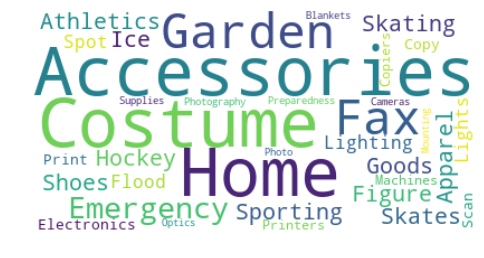

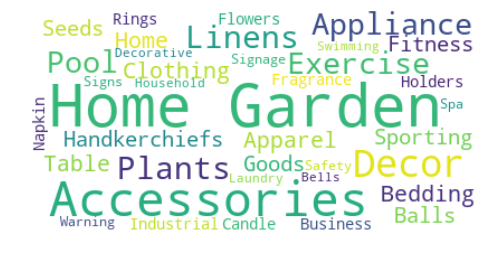

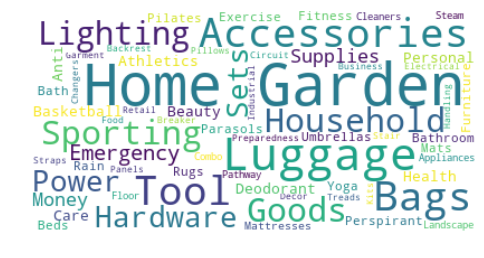

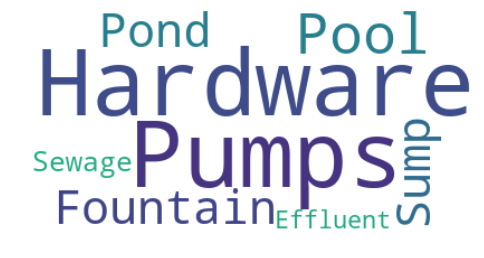

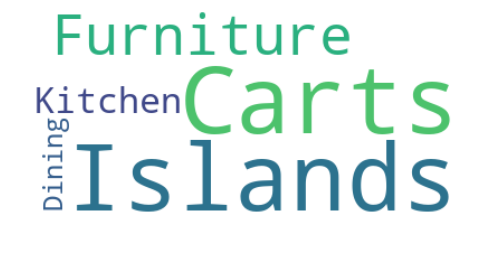

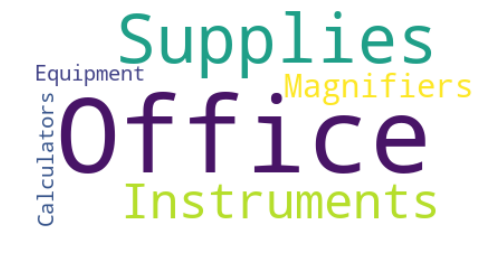

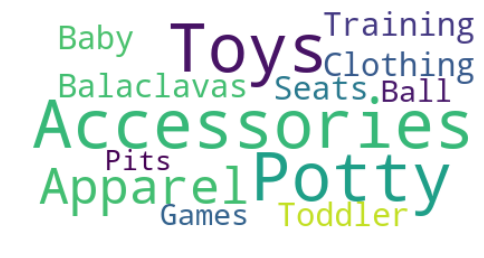

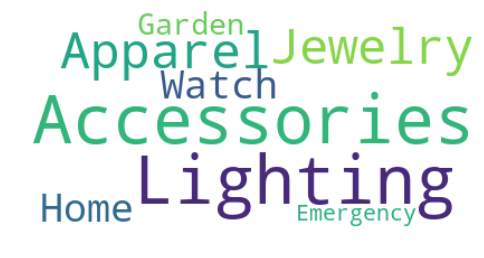

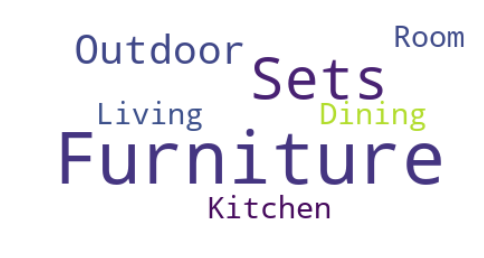

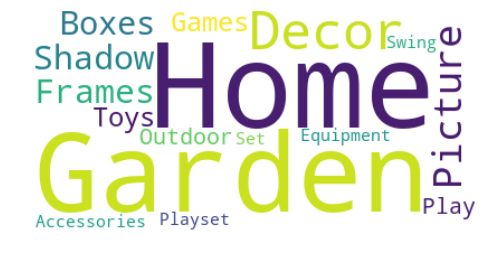

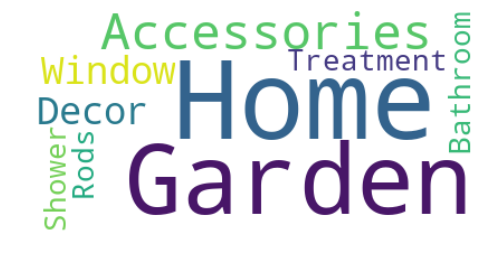

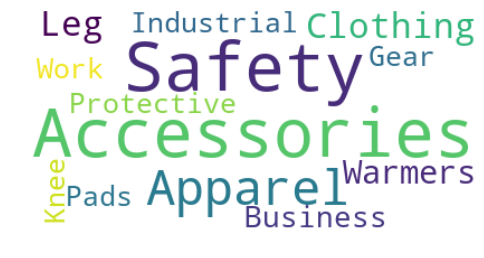

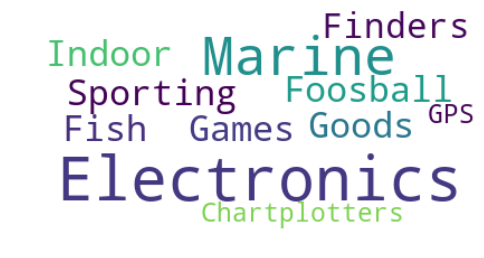

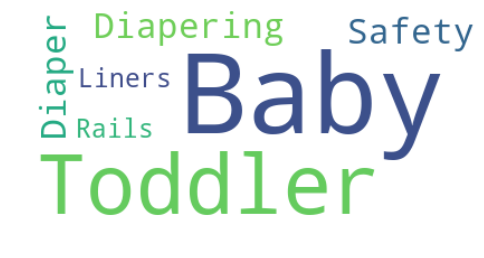

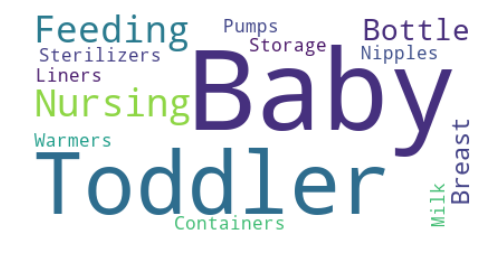

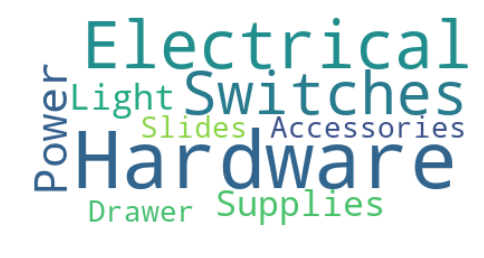

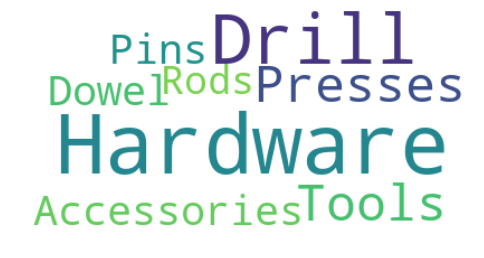

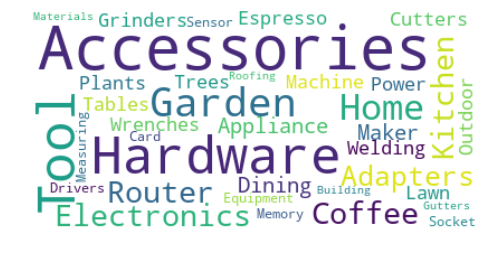

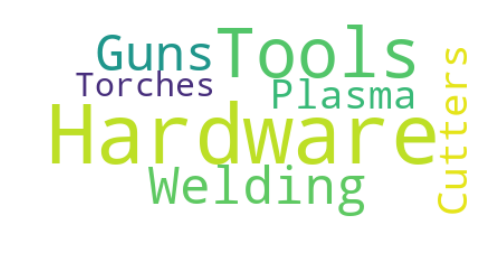

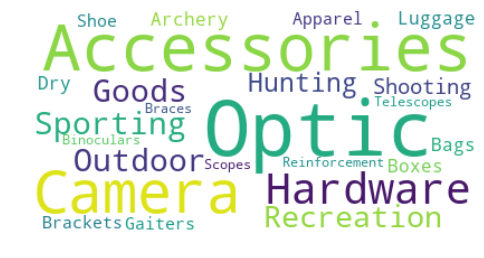

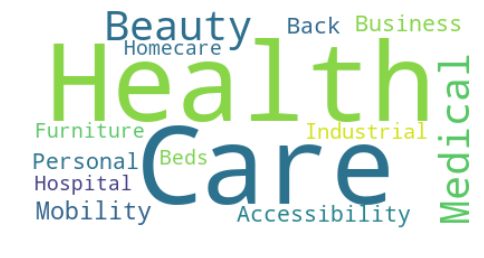

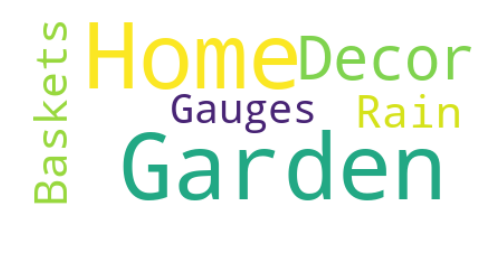

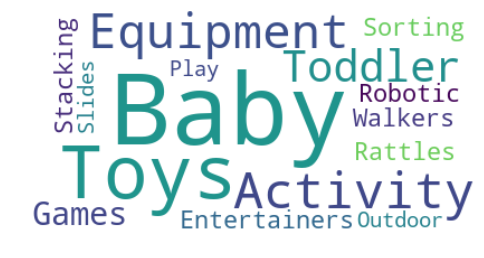

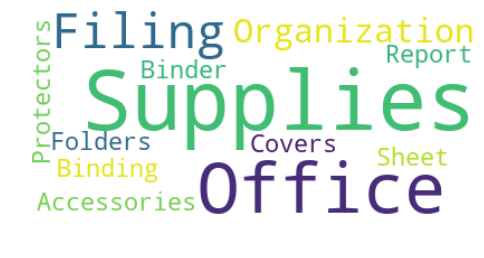

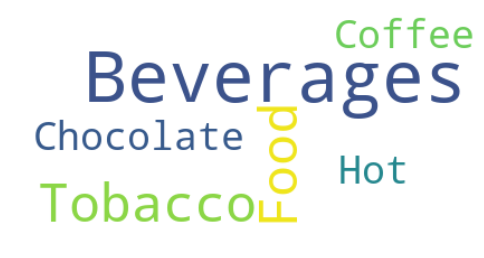

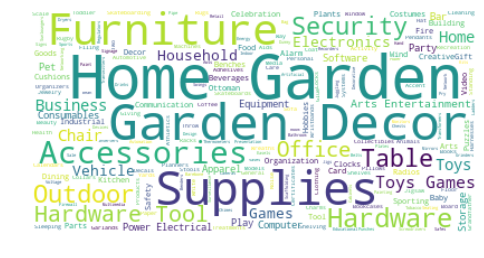

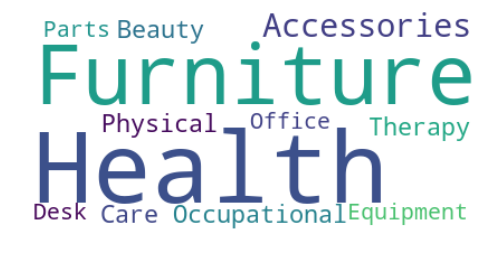

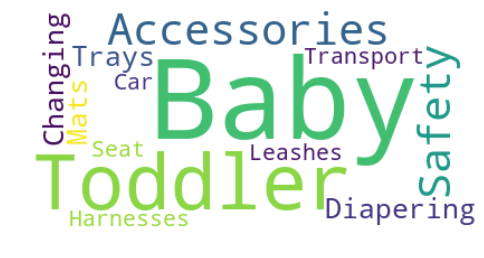

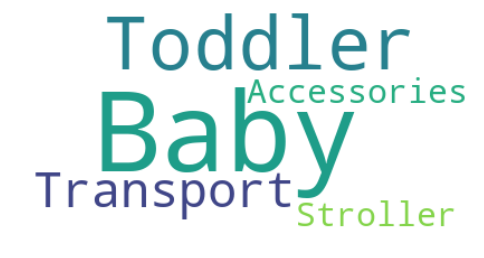

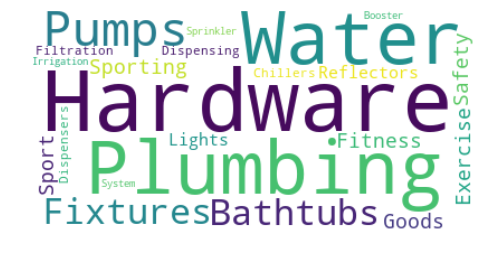

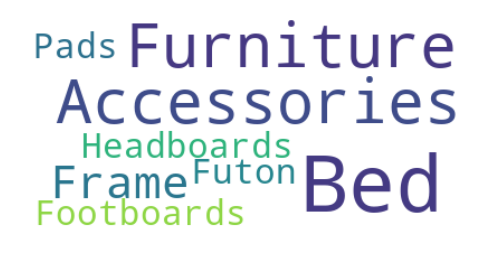

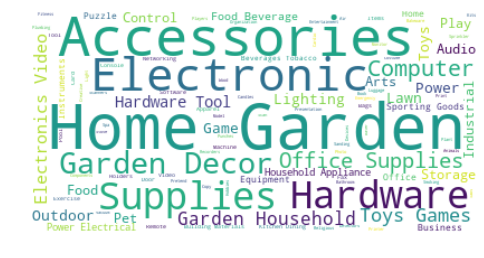

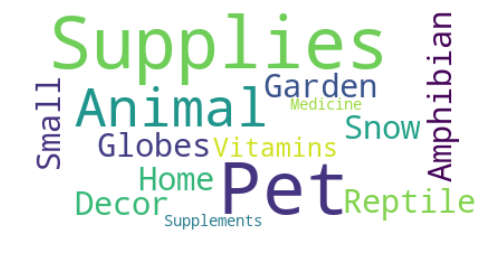

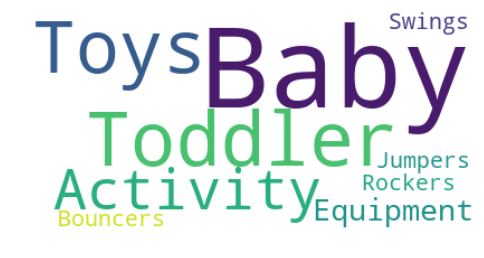

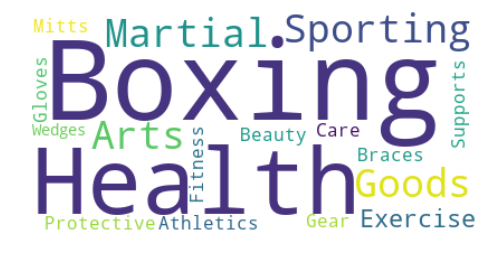

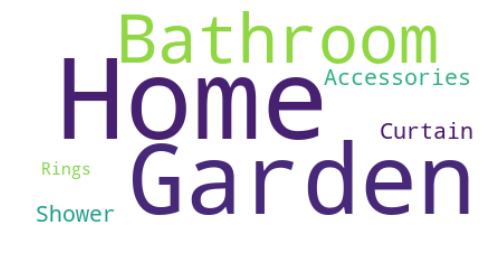

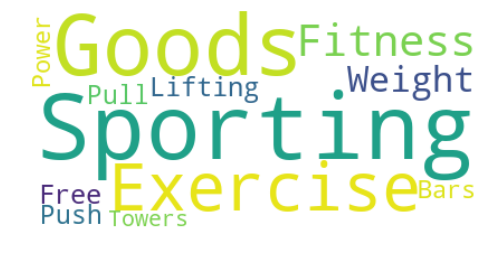

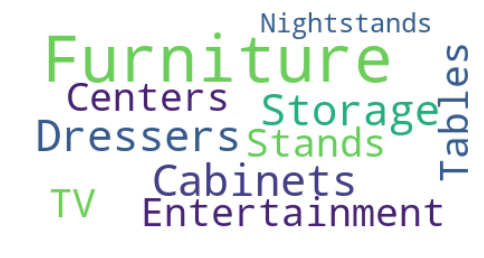

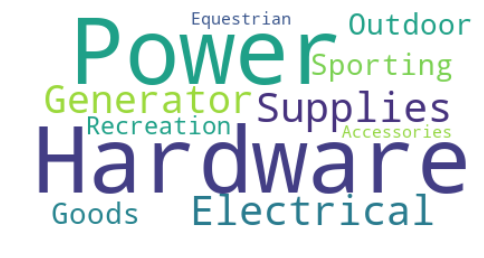

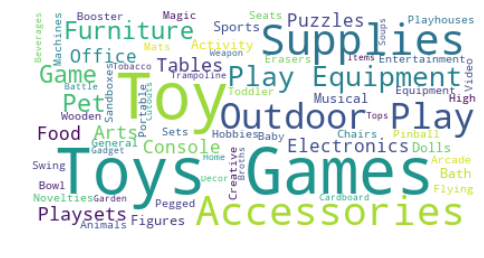

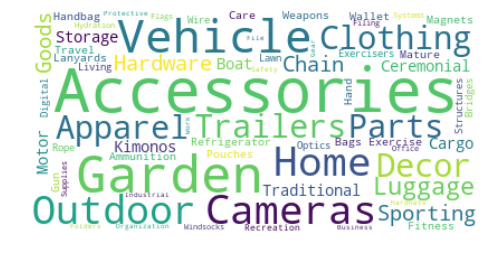

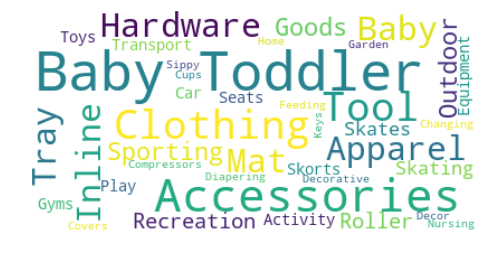

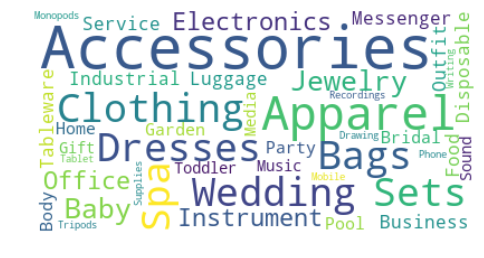

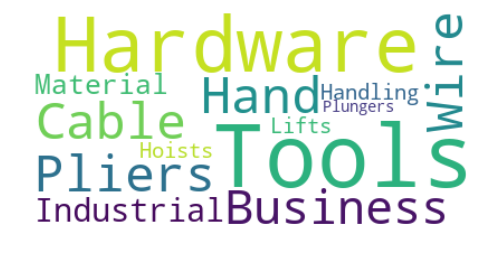

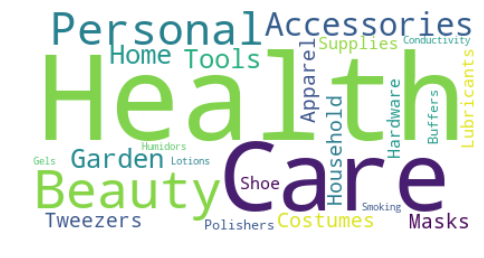

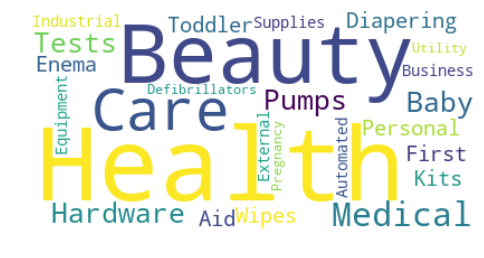

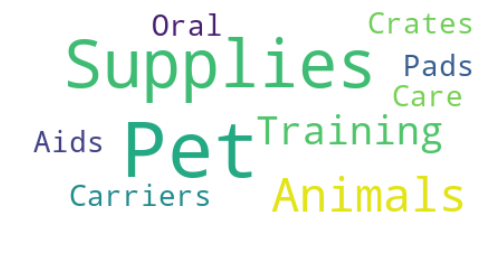

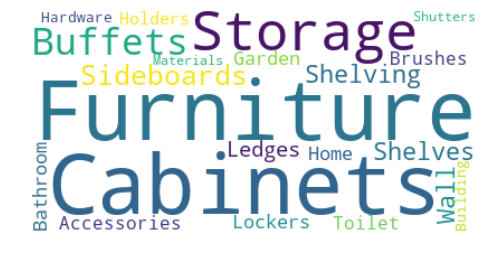

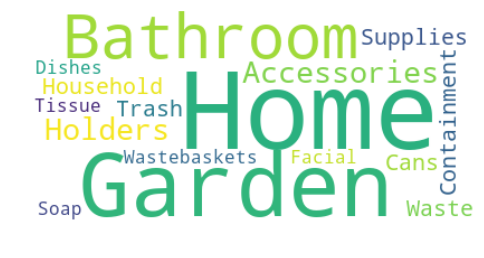

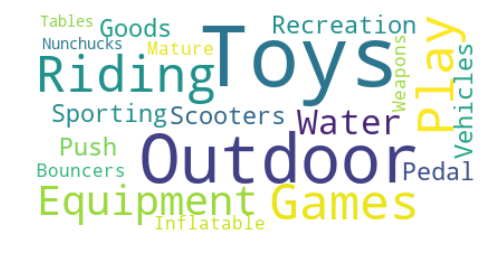

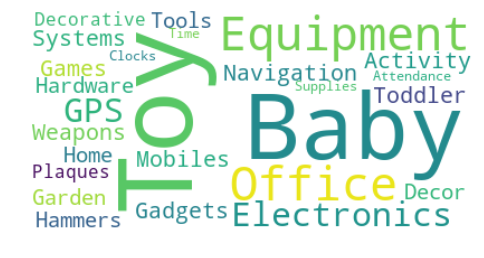

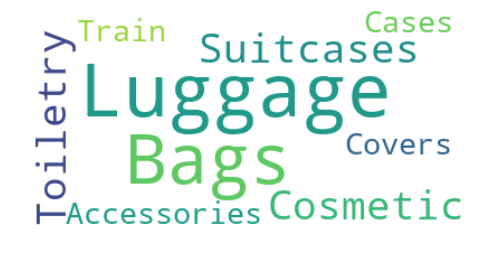

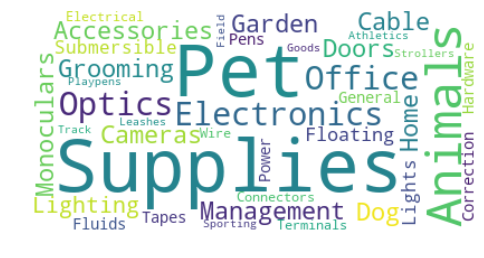

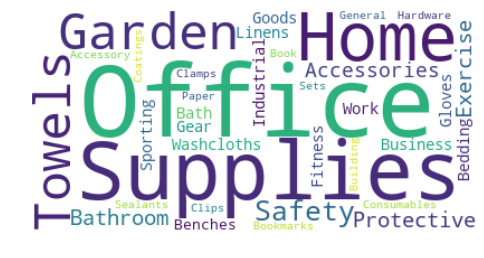

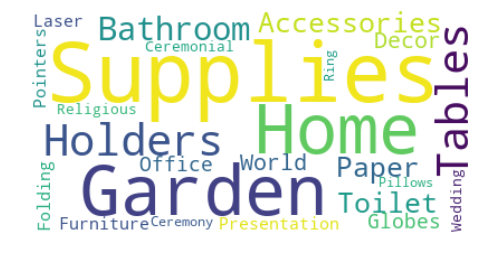

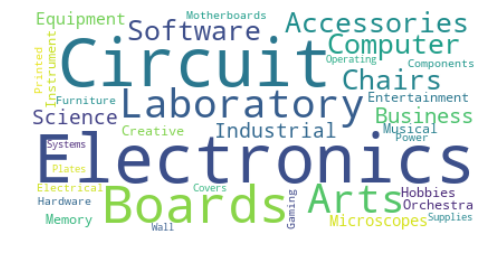

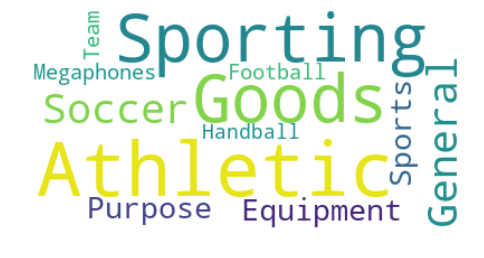

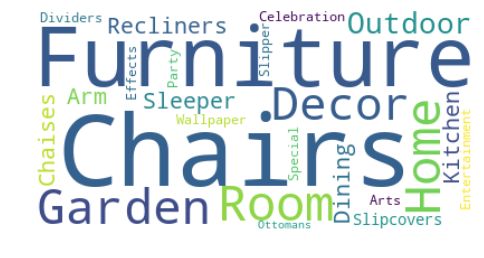

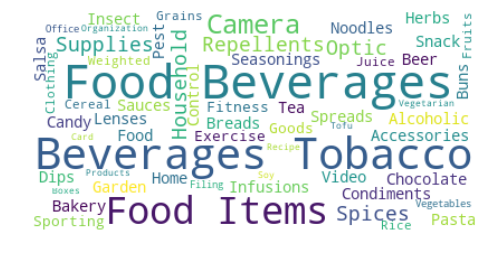

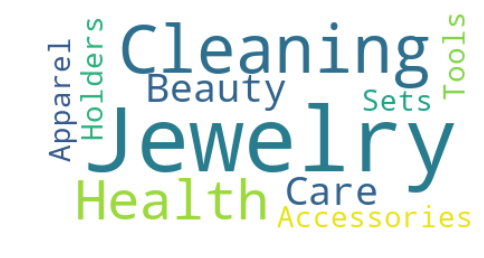

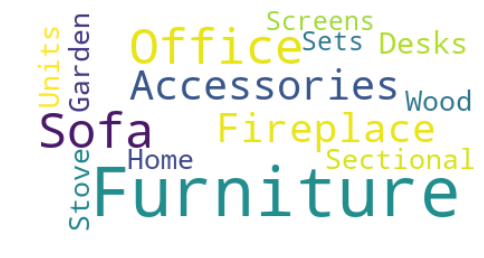

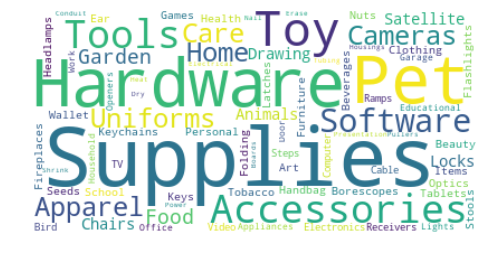

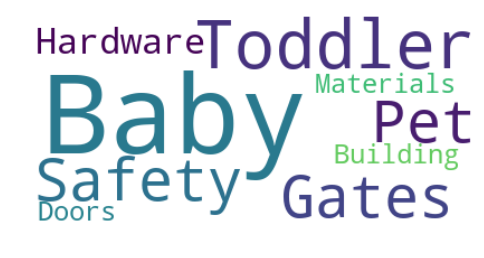

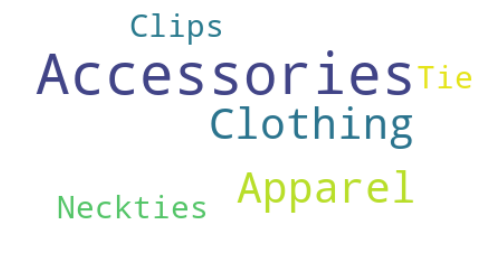

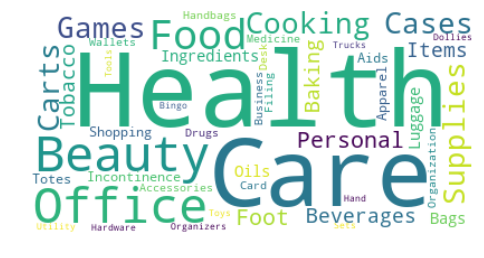

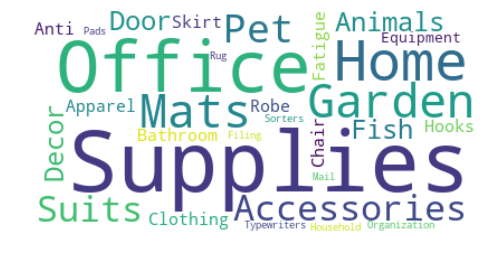

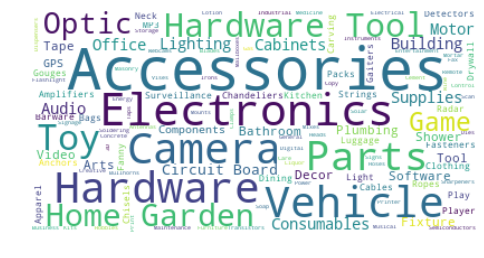

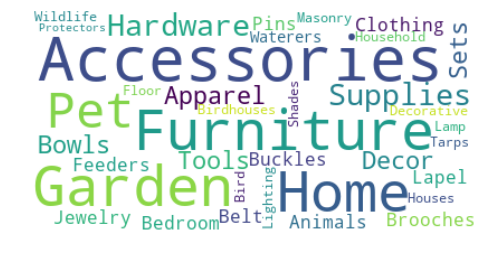

In [0]:
dict_sentences = create_sentences_for_each_cluster(df)
for k in range(len(dict_sentences)):
  wordcloud = WordCloud(background_color="white").generate(dict_sentences[k])
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  

### Appendices

In [0]:
def eigenDecomposition(A, plot = True):
    L = csgraph.laplacian(A, normed = True)
    n_components = A.shape[0]
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which = 'LM', sigma = 1.0, maxiter = 5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    nb_clusters = index_largest_gap + 1
    return nb_clusters, eigenvalues, eigenvectors